# 环境

In [1]:
import pandas as pd
import numpy  as np
import rqrisk as rq
import empyrical as ep
import inspect 

# 收益率
1. 算数收益率：$r_t=\frac{P_t-P_{t-\Delta t}}{P_{t-\Delta t}}=\frac{P_t}{P_{t-\Delta t}}-1$
2. 对数收益率：$r_t=\ln\frac{P_t}{P_{t-\Delta t}}$

可加性

In [2]:
a,b=.1,.05

In [3]:
# 算数收益率连乘
1*(1+a)*(1+b)

1.1550000000000002

In [4]:
# 对数收益率连加
1*np.e**a*np.e**b,1*np.e**(a+b)

(1.1618342427282833, 1.161834242728283)

对称性

In [5]:
p1,p2=3.4,3.5

In [6]:
# 算数收益率不对称
p2/p1-1,p1/p2-1

(0.02941176470588247, -0.02857142857142858)

In [7]:
# 对数收益率对称
np.log(p2/p1),np.log(p1/p2)

(0.028987536873252406, -0.028987536873252298)

# 模拟数据

In [8]:
# 对数收益率
n=1000
np.random.seed(8)
df_r=pd.DataFrame(
    index=pd.date_range(start='2011-1-1',periods=n,),
    data={
        'portfolio':np.random.normal(loc=.0002,scale=.002,size=n),
        'benchmark':np.random.normal(loc=.0001,scale=.001,size=n)
    }
)
df_r.head()

,portfolio,benchmark
2011-01-01,0.000382,-0.001022
2011-01-02,0.002383,-0.000158
2011-01-03,-0.003694,0.000414
2011-01-04,-0.002573,0.000282
2011-01-05,-0.004393,0.000980


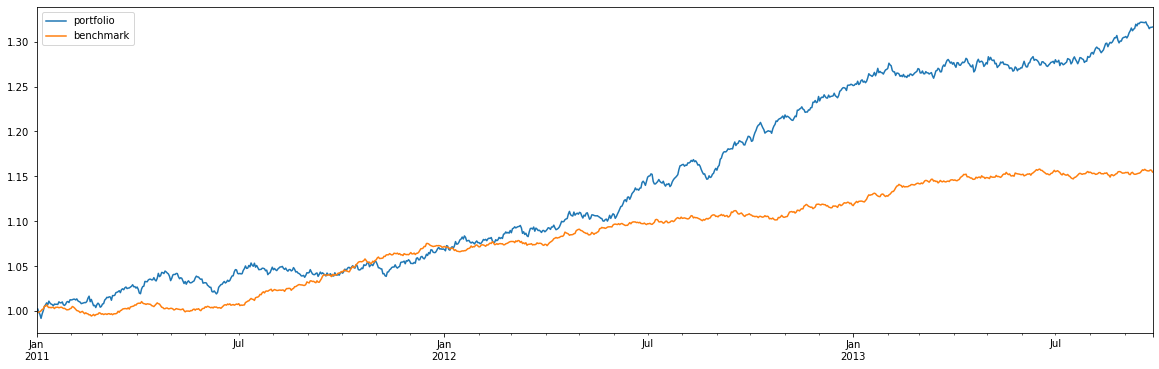

In [9]:
df_v=1*np.exp(df_r.cumsum(axis=0))
df_v.plot(figsize=(20,6))

# 每日收益率
$r_t=\ln\frac{P_t}{P_{t-1}}$

In [10]:
np.log(df_v.pct_change(periods=1)+1)

,portfolio,benchmark
2011-01-01,NaN,NaN
2011-01-02,0.002383,-0.000158
2011-01-03,-0.003694,0.000414
2011-01-04,-0.002573,0.000282
2011-01-05,-0.004393,0.000980
...,...,...
2013-09-22,-0.001092,-0.000240
2013-09-23,-0.002277,0.000113
2013-09-24,0.001075,0.000898
2013-09-25,0.000065,-0.000393


# 回测收益率
$r=\sum_{i=1}^n{r_i}$

In [11]:
df_r.sum(axis=0)

portfolio    0.274712
benchmark    0.143993
dtype: float64

$r=\ln\frac{p_t}{p_0}$

In [12]:
np.log(df_v.iloc[-1,:]/1)

portfolio    0.274712
benchmark    0.143993
Name: 2013-09-26 00:00:00, dtype: float64

# 年化收益率
$r=\frac{\sum_{i=1}^n{r_i}}{n}\times 250$

In [13]:
df_r.sum(axis=0)/n*250

portfolio    0.068678
benchmark    0.035998
dtype: float64

In [14]:
# 平均收益率（日化收益率）
df_r.mean(axis=0)*250

portfolio    0.068678
benchmark    0.035998
dtype: float64

$r=\ln\frac{p_t}{p_0}$

In [15]:
np.log(df_v.iloc[-1,:]/1)/n*250

portfolio    0.068678
benchmark    0.035998
Name: 2013-09-26 00:00:00, dtype: float64

# 对数收益率转简单收益率

In [16]:
df_r_s=np.expm1(df_r)

# 绩效分析库

rqrisk（rqalpha）empyrical（quantopian）

1. rqrisk
    1. Risk对象的入参为简单收益率序列
    2. alpha为年化alpha

# rqrisk

In [17]:
risk=rq.Risk(
    daily_returns=df_r_s.portfolio,
    benchmark_daily_returns=df_r_s.benchmark,
    risk_free_rate=.0,
    period=rq.DAILY,
)

## return_rate
回测收益率：$r=\frac{p_n-p_0}{p_0}$

In [64]:
risk.return_rate

0.31615157460340576

$\large\frac{p_n}{p_0}=\exp^{\sum_{i=0}^{n-1}{\ln\frac{p_{(i+1)}}{p_{i}}}}$

In [19]:
np.expm1(np.log1p(df_r_s.portfolio).sum())

0.31615157460340576

由对数收益率求简单收益率

In [20]:
np.expm1(df_r.portfolio.sum())

0.31615157460340565

## benchmark_return

In [21]:
risk.benchmark_return

0.15487643432910764

In [22]:
np.expm1(df_r.benchmark.sum())

0.15487643432910764

## annual_return
年化收益率：使得策略之间具有可比较性

In [23]:
risk.annual_return

0.07167990839338634

In [24]:
(1 + risk.return_rate) ** (rq.risk.APPROX_BDAYS_PER_YEAR/df_r_s.shape[0]) - 1

0.07167990839338634

In [25]:
np.expm1(df_r.portfolio.mean()*rq.risk.APPROX_BDAYS_PER_YEAR)

0.07167990839338628

## benchmark_annual_return

In [26]:
risk.benchmark_annual_return

0.03695270994707589

In [27]:
np.expm1(df_r.benchmark.mean()*rq.risk.APPROX_BDAYS_PER_YEAR)

0.03695270994707582

## beta
贝塔：CAPM模型中市场基准组合项的系数，表示资产收益对市场整体收益波动的敏感程度。

$\beta=\frac{Cov}{Var}$

In [28]:
risk.beta

0.005740187920329941

In [29]:
df_r_s.cov()

,portfolio,benchmark
portfolio,4.180896e-06,5.582852e-09
benchmark,5.582852e-09,9.725905e-07


In [30]:
_x=df_r_s.cov()
_x.iloc[1,0]/_x.iloc[1,1]

0.005740187920329941

## alpha
阿尔法: CAPM模型表达式中的残余项。表示策略所持有投资组合的收益中和市场整体收益无关的部分，是策略选股能力的度量。当策略所选股票的总体表现优于市场基准组合成分股时，阿尔法取正值；反之取负值。

$\alpha=E[r_p-[r_f+\beta(r_b-r_f)]]$

In [31]:
risk.alpha

0.06955406871897851

In [32]:
(df_r_s.portfolio-risk.beta*df_r_s.benchmark).mean()*rq.risk.APPROX_BDAYS_PER_YEAR

0.06955406871897851

**注：此处阿尔法为年化值**

## volatility
波动率: 策略收益率的标准差，最常用的风险度量。波动率越大，策略承担的风险越高。

$\sigma=\sqrt{\frac{\sum_{i=1}^{n}{{[r_{pi}-\bar{r_{p}}]}^2\times I(i)}}{n-1}}$

In [33]:
risk.volatility

0.0020447239621592724

In [34]:
df_r_s.portfolio.std()

0.0020447239621592724

## annual_volatility
$\sigma_a=\sigma\times\sqrt{252}$

In [35]:
risk.annual_volatility

0.03245898662188848

In [36]:
df_r_s.portfolio.std()*rq.risk.APPROX_BDAYS_PER_YEAR**(1/2)

0.03245898662188848

## benchmark_volatility

In [37]:
risk.benchmark_volatility

0.0009862000468975104

In [38]:
df_r_s.benchmark.std()

0.0009862000468975104

## benchmark_annual_volatility

In [39]:
risk.benchmark_annual_volatility

0.015655440402306296

In [40]:
df_r_s.benchmark.std()*rq.risk.APPROX_BDAYS_PER_YEAR**(1/2)

0.015655440402306296

## downside_risk
下行波动率: 相比波动率，下行波动率对收益向下波动和向上波动两种情况做出了区分，并认为只有收益向下波动才意味着风险。在实际计算中，我们统一使用基准组合收益为目标收益，作为向上波动和向下波动的判断标准。

$\large\sigma_d=\sqrt{\frac{\sum_{i=1}^{n}{{[r_{pi}-r_{bi}]}^2\times I(i)}}{n-1}}\\
I(i)=\left\{\begin{matrix}
1 & ,r_{pi}<r_{bi} \\ 
0& ,r_{pi}\geq r_{bi} 
\end{matrix}\right.
$

In [41]:
risk.downside_risk

0.0015260218064484805

In [42]:
_x=(df_r_s.portfolio-df_r_s.benchmark)
_x[_x>0]=0
((_x**2).sum()/(_x.shape[0]-1))**(1/2)

0.0015260218064484805

## annual_downside_risk

$\large\sigma_d=\sqrt{252\frac{\sum_{i=1}^{n}{{[r_{pi}-r_{bi}]}^2\times I(i)}}{n-1}}\\
I(i)=\left\{\begin{matrix}
1 & ,r_{pi}<r_{bi} \\ 
0& ,r_{pi}\geq r_{bi} 
\end{matrix}\right.
$

In [43]:
risk.annual_downside_risk

0.024224845170745333

In [44]:
_x=(df_r_s.portfolio-df_r_s.benchmark)
_x[_x>0]=0
((_x**2).sum()/(_x.shape[0]-1)*rq.risk.APPROX_BDAYS_PER_YEAR)**(1/2)

0.024224845170745333

## max_drawdown
最大回撤比率：描述策略可能出现的最糟糕情况；

$MaxDrawdown=Max\left(\frac{(p_x-p_y)}{p_x}\right),y>x$,即时点y在x时间之后。

In [48]:
risk.max_drawdown

-0.02436038534438428

In [49]:
max_return = np.maximum.accumulate(df_v)
((df_v - max_return) / max_return).min()

portfolio   -0.024360
benchmark   -0.012392
dtype: float64

## sharpe
夏普比例：表示每承受一单位风险，会产生多少的超额回报，可以同时对策略的收益和风险进行综合考虑。

$Sharpe\ \ Ratio=\frac{r_p-r_f}{\sigma_p}\
r_p:策略平均收益率；\
r_f:无风险收益率；
\sigma_p:策略收益波动率；$

**夏普比率年化**

In [51]:
risk.sharpe

2.149268471664546

In [52]:
df_r_s.mean()/df_r_s.std(ddof=1)*rq.risk.APPROX_BDAYS_PER_YEAR**(1/2)

portfolio    2.149268
benchmark    2.325794
dtype: float64

## information_ratio
信息比率：衡量策略相对于市场基准的表现。一般用于评估纯多头的主动交易策略（包括阿尔法策略和基准择时策略）。需要注意的是，信息率不适用于多-空结合的对冲策略的表现评估。

$\large Information\ \ Ratio=\frac{r_p-r_m}{\sigma_{pm}}$

In [53]:
risk.information_ratio

0.9264858378717644

In [54]:
excess=df_r_s.portfolio-df_r_s.benchmark
excess.mean()/excess.std(ddof=1)*rq.risk.APPROX_BDAYS_PER_YEAR**(1/2)

0.9264858378717643

## sortino
索提诺比率：用于度量承担一个单位下行风险获得的超额收益。

$\large Sortino\ \ Ratio=\frac{r_p-r_f}{\sigma_{pd}};\\
r_p-r_f:超额收益\\
\sigma_{pd}:策略下行风险$

In [55]:
risk.sortino

0.18141130373180098

**rqrisk:索提诺比率bug**

In [58]:
df_r_s.portfolio.mean()/risk.downside_risk*rq.risk.APPROX_BDAYS_PER_YEAR**(1/2)

2.8798151681420947

## calmar
卡玛尔比率（风报比）：描述的是收益和最大回撤之间的关系。和夏普比率的适用场景相似，相比于夏普比率，卡玛尔指标对于风险更加严格。在期货CTA策略市场应用比较广泛。

$Calmar\ \ Ratio=\frac{r_p}{md}$

In [63]:
risk.calmar

2.9424784288114916

In [65]:
risk.annual_return/-risk.max_drawdown

2.9424784288114916

**小结；**
1. 信息率用于评估投资组合相对于市场基准组合的表现，一般适用于纯多头的主动交易策略（包括阿尔法策略和基准择时策略）；
2. 夏普率用于评估投资组合相对于无风险组合的表现，一般适用于多-空结合的交易策略（例如市场中性策略或配对交易策略），或没有公认市场基准组合的投资品种的交易策略（例如期货CTA策略）；
3. 索提诺比率使用下行波动率作为风险度量，因而有别于信息率和夏普率。下行波动率区分了收益向上波动和向下波动两种情况，并认为收益向下波动才代表风险。因此，索提诺比率的优点，在于其使用的风险度量更为切合我们实际投资中面对的风险；而其缺点则是不如信息率和夏普率常用，认知度较低；
4. 卡玛尔指标与夏普指标的适用策略类型相同。不同于夏普比例的是，除了分母（风险的定义）不同，分子卡玛尔是策略的年化收益，二夏普是相对于无风险收益的年化超额收益；

## tracking_error
跟踪误差:用于衡量策略收益和市场基准收益之间的差异。跟踪误差越大，表明策略所持有投资组合偏离基准组合的程度越大。

**注:**该指标适宜评估纯多头策略，不适于评估多空结合的对冲策略。

$Tracking\ \ Error=超额收益（相对于基准组合）的标准差$

In [59]:
risk.tracking_error

0.0022676686065377346

In [60]:
excess.std(ddof=1)

0.0022676686065377346

## annual_tracking_error

In [61]:
risk.annual_tracking_error

0.03599812313284335

In [62]:
risk.tracking_error*rq.risk.APPROX_BDAYS_PER_YEAR**(1/2)

0.03599812313284335

## var
风险价值(在险价值)，是指在正常市场环境下，一项投资在给定置信度水平和持有期间内预期的最大损失。

例如：
某公司在2013年某一天置信度为95%的VaR值为1000万美元。其含义是指：该公司可以以95%的可能性保证，在这一天由于市场波动而带来的损失不会超过1000万美元。

In [66]:
risk.var

0.003090820319162627

**注：**bug

In [68]:
-np.expm1(-np.log1p(risk.var))

0.0030812965850681323

**注：**此处指的的是在险价值相对于资产总值的比例；

## excess_return_rate
超额收益率：指的是相对于市场基准的超额收益率

In [72]:
risk.excess_return_rate

0.1385681786135742

In [70]:
risk_d=rq.Risk(
    daily_returns=df_r_s.portfolio-df_r_s.benchmark,
    benchmark_daily_returns=df_r_s.benchmark,
    risk_free_rate=.0,
    period=rq.DAILY,
)

In [73]:
risk_d.return_rate

0.1385681786135742

## excess_annual_return

In [74]:
risk.excess_annual_return,risk_d.annual_return

(0.033243016183872154, 0.033243016183872154)

## excess_volatility

In [75]:
risk.excess_volatility,risk_d.volatility

(0.0022676686065377346, 0.0022676686065377346)

## excess_annual_volatility

In [76]:
risk.excess_annual_volatility,risk_d.annual_volatility

(0.03599812313284335, 0.03599812313284335)

## excess_sharpe

In [77]:
risk.excess_sharpe,risk_d.sharpe

(1.0249460031739204, 0.9264858378717644)

## excess_max_drawdown

In [78]:
risk.excess_max_drawdown,risk_d.max_drawdown

(-0.0618288208207461, -0.0618288208207461)

## avg_excess_benchmark_return

In [79]:
risk.avg_excess_benchmark_return

0.00013234821933548932

# empyrical

## aggregate_returns
收益率序列的降采样

In [80]:
ep.aggregate_returns(returns=df_r_s.portfolio,convert_to=ep.YEARLY)

2011    0.069395
2012    0.170729
2013    0.051263
Name: portfolio, dtype: float64

## alpha_beta_aligned

In [84]:
ep.alpha_beta_aligned(
    returns=df_r_s.portfolio,
    factor_returns=df_r_s.benchmark,
    period=ep.DAILY,
)

array([0.07201973, 0.00574019])

In [85]:
risk.alpha,risk.beta

(0.06955406871897851, 0.005740187920329941)

**注：**rqrisk和empyrical对应指标不一致的时候，建议以rqrisk为准

## annual_return

In [86]:
ep.annual_return(
    returns=df_r_s.portfolio
)

0.07167990839338612

In [87]:
risk.annual_return

0.07167990839338634

## annual_volatility

In [88]:
ep.annual_volatility(
    returns=df_r_s.portfolio
)

0.03245898662188848

In [90]:
risk.annual_volatility

0.03245898662188848

## calmar_ratio

In [91]:
ep.calmar_ratio(returns=df_r_s.portfolio)

2.942478428811395

In [92]:
risk.calmar

2.9424784288114916

## capture
策略收益与基准收益的比值

In [93]:
ep.capture(returns=df_r_s.portfolio,factor_returns=df_r_s.benchmark)

1.9397740651780866

In [94]:
risk.annual_return/risk.benchmark_annual_return

1.9397740651780926

## conditional_value_at_risk

In [97]:
-ep.conditional_value_at_risk(returns=df_r_s.portfolio)

0.003923452390847673

In [96]:
-np.expm1(-np.log1p(risk.var))

0.0030812965850681323

## cum_returns
累积收益序列

In [98]:
ep.cum_returns(returns=df_r_s.portfolio)

2011-01-01    0.000382
2011-01-02    0.002769
2011-01-03   -0.000929
2011-01-04   -0.003496
2011-01-05   -0.007864
                ...   
2013-09-22    0.317325
2013-09-23    0.314329
2013-09-24    0.315742
2013-09-25    0.315828
2013-09-26    0.316152
Freq: D, Length: 1000, dtype: float64

## cum_returns_final

In [99]:
ep.cum_returns_final(returns=df_r_s.portfolio)

0.3161515746034047

In [100]:
risk.return_rate

0.31615157460340576

## down

### down_alpha_beta

In [101]:
ep.down_alpha_beta(returns=df_r_s.portfolio,factor_returns=df_r_s.benchmark)

array([ 0.07013213, -0.09447796])

### down_capture
市场基准为负收益期间，对应的组合年化收益和市场年化收益的比值

In [102]:
ep.down_capture(returns=df_r_s.portfolio,factor_returns=df_r_s.benchmark)

-0.5314256940919653

## downside_risk

In [103]:
ep.downside_risk(returns=df_r_s.portfolio),risk.downside_risk

(0.02060619708743594, 0.0015260218064484805)

## excess_sharpe

In [104]:
ep.excess_sharpe(returns=df_r_s.portfolio,factor_returns=df_r_s.benchmark),risk.excess_sharpe

(0.05836312191028562, 1.0249460031739204)

## max_drawdown

In [105]:
ep.max_drawdown(returns=df_r_s.portfolio),risk.max_drawdown

(-0.024360385344385, -0.02436038534438428)

## omega_ratio

正收益累计值与负收益累计值的绝对值的比值；

In [106]:
ep.omega_ratio(returns=df_r_s.portfolio)

1.4055616095674364

## roll
是用来滚动计算绩效分析指标序列

### roll_alpha_beta_aligned

In [109]:
ep.roll_alpha_beta_aligned(df_r_s.portfolio,df_r_s.benchmark,1000)

,0,1
2013-09-26,0.07202,0.00574


In [110]:
ep.alpha_beta_aligned(
    returns=df_r_s.portfolio,
    factor_returns=df_r_s.benchmark,
    period=ep.DAILY,
)

array([0.07201973, 0.00574019])

## sharpe_ratio

In [111]:
ep.sharpe_ratio(returns=df_r_s.portfolio),risk.sharpe

(2.1492684716645454, 2.149268471664546)

## sortino_ratio

In [112]:
ep.sortino_ratio(returns=df_r_s.portfolio),risk.sortino

(3.3855386451264353, 0.18141130373180098)

## stability_of_timeseries

In [113]:
ep.stability_of_timeseries(returns=df_r_s.portfolio)

0.9566504648084717

## tail_ratio
95分位和5分位绝对值的比值

In [114]:
ep.tail_ratio(returns=df_r_s.portfolio)

1.1550975269059238

## value_at_risk

In [116]:
-ep.value_at_risk(returns=df_r_s.portfolio),-np.expm1(-np.log1p(risk.var))

(0.003102760322564865, 0.0030812965850681323)